# Image segmentation and calcium imaging ROI analysis lab

`Author:  Corey Webster, MCB PhD student in the Feller Lab at UC Berkeley`

`The Watershed Image Segmentation part of this tutorial comes from Luis Pedro Coelho and can be found at his github repository `[HERE](https://github.com/luispedro/python-image-tutorial/)

The goal of this tutorial is to familiarize you with some available tools in python for the purpose of automated ROI segmentation and analysis of calcium imaging traces. This tutorial should provide you with some foundation so that you can explore and develop image analysis tools in the future. 

In the first kernel of python code, we import the necessary libraries and tools. The first library that we import is [mahotas](http://mahotas.readthedocs.io/en/latest/edf.html), which has a lot of useful tools for image segmentation, particularly for images with biological information. 

In [1]:
import numpy as np
import mahotas as mh
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Setting some defaults for our plots
plt.rcParams['figure.figsize'] = (10.0, 8.0) #10x8 inches
plt.rcParams['image.cmap'] = 'gray' #set default colormap

Mahotas includes demo images, such as one of cells with a nuclear stain, feel free to uncomment the 'nuclear' demo image and play with segmentation using that (also uncomment the axis to make a single channel image from RGB). For this tutorial we'll be working with calcium imaging data from Muller Glia in the retina. The first image is an average intensity projection of the whole stack. Don't worry that it's glia, the algorithm should work with neurons also!

In [3]:
dna = mh.imread('MullerGlia_sample2.tif')
print(dna.shape)

(256, 256)


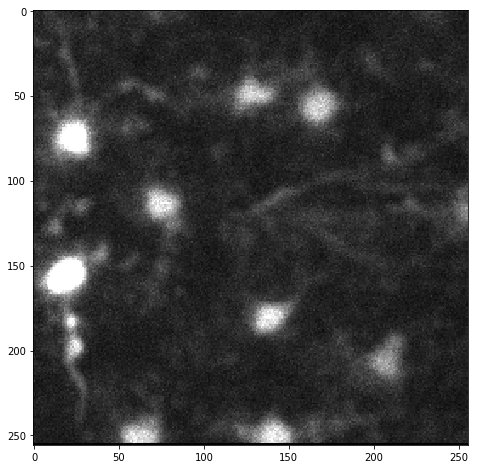

In [4]:
_ = plt.imshow(dna)

### Threshold
The next step is to threshold our average intensity projection so that we can approximate regions of interest before putting it through further filters. You can play around with the threshold to see what works best. 

In [5]:
@interact(thresh=(0.,4.0,0.05)) #between 1.0 and 16.0
def check_thresh(thresh):
    T_mean = thresh * dna.mean()  
    _ = plt.imshow(dna > T_mean)

interactive(children=(FloatSlider(value=2.0, description='thresh', max=4.0, step=0.05), Output()), _dom_classe…

#### Scroll through the different thresholding values.  What differences do you notice when you change the value?  Explain the logic of how you selected a threshold value.

### Gaussian filter
Mahotas has a [gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) function that is similar to FIJIs gaussian filter. 

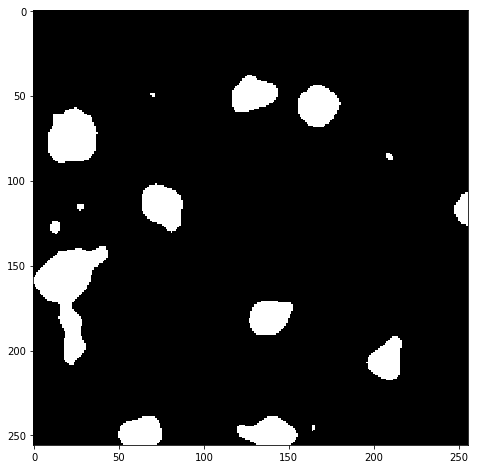

In [6]:
#thresh_val = ??? # put the value that you chose here
thresh_val = 1.7 # put the value that you chose here

dnaf = mh.gaussian_filter(dna, 2.)
T_mean = thresh_val * dnaf.mean()
bin_image = dnaf > T_mean
_ = plt.imshow(bin_image)

Now we'll take the smoothened binary image and label it by assigning a different index to each region and then represent that index using the jet color map.  

15


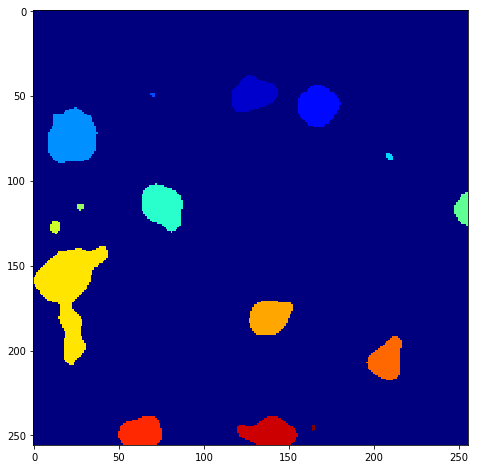

In [7]:
labeled, nr_objects = mh.label(bin_image)
print(nr_objects)

plt.imshow(labeled)
plt.jet()

### Separating touching cells
We now have the cells nicely separated from the background, but we have also merged several cells together.

The general strategy we can use to separate the cells is the following:

1. Smooth the image with a Gaussian filter (we need to specify the  $\sigma$ parameter)
2. Find regional maxima on this smoothed image to identify each cell
3. Use [watershed](https://en.wikipedia.org/wiki/Watershed_(image_processing%29) on the [distance transformed](https://en.wikipedia.org/wiki/Distance_transform) image to separate cells.

Play around with the interactive mode function to find the best value for $\sigma$:



In [8]:
@interact(sigma=(0.5,16.)) #between 1.0 and 16.0
def check_sigma(sigma):
    dnaf = mh.gaussian_filter(dna.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(dnaf))
    maxima = mh.dilate(maxima, np.ones((5,5)))
    plt.imshow(mh.as_rgb(np.maximum(255*maxima, dnaf), dnaf, dna > T_mean))

interactive(children=(FloatSlider(value=8.25, description='sigma', max=16.0, min=0.5), Output()), _dom_classes…

#### Explain the logic behind how you chose a value for sigma.

Input the sigma we just found into the gaussian filter to calculate the maxima for the watershed. 

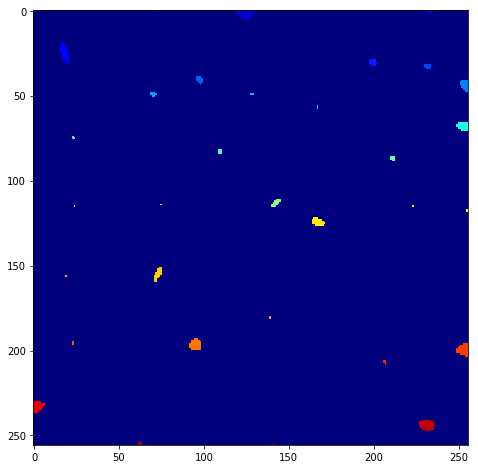

In [9]:
#sigma = ??? # put the value that you chose here
sigma = 6 # put the value that you chose here
dnaf = mh.gaussian_filter(dna.astype(float), sigma)
maxima = mh.regmax(mh.stretch(dnaf))
maxima,_ = mh.label(maxima)
_ = plt.imshow(maxima)

### Distance Transform
Calculate the distance transform to use for the watershed. Mahotas conveniently has a distance function. 

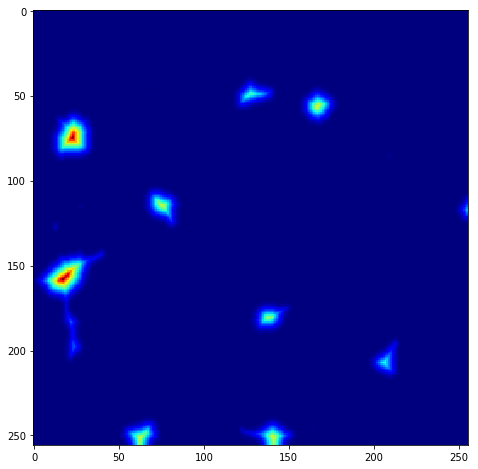

In [10]:
dist = mh.distance(bin_image)
_ = plt.imshow(dist)

### Run Watershed

Because of the way that the watershed function is defined in mahotas, we need to invert the distance transform. Also, for technical reasons, we convert to uint8.

Finally, we can call mh.cwatershed with the dist image and the maxima as seeds. 

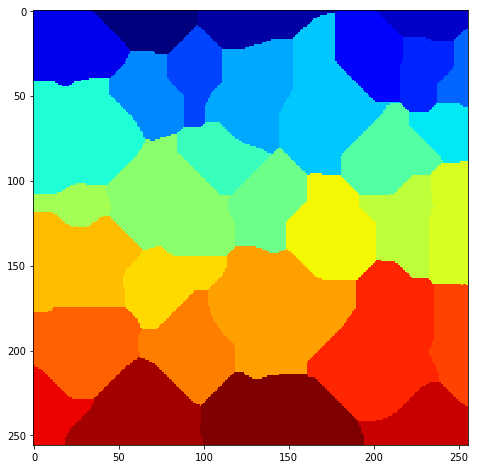

In [11]:
dist = 255 - mh.stretch(dist)
watershed = mh.cwatershed(dist, maxima)
_ = plt.imshow(watershed)

Now we can use the binary image as a mask to remove the background and we have our segmented cells. 

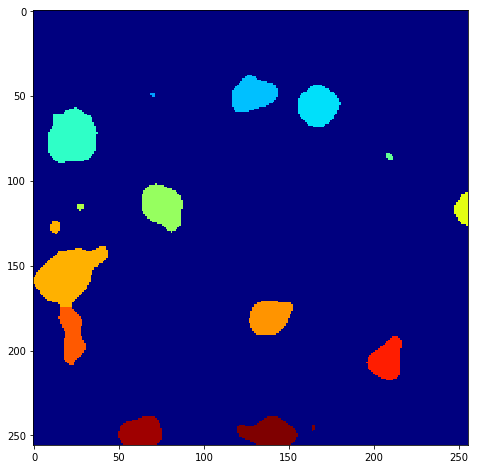

In [12]:
watershed *= bin_image
_ = plt.imshow(watershed)

### Cleaning up regions

We'll just run a few size filters and remove regions that touch the border since we might not get complete information from those ROIs. 

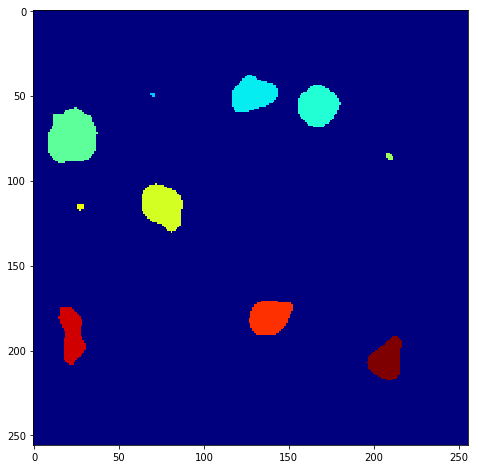

In [13]:
watershed = mh.labeled.remove_bordering(watershed)
_ = plt.imshow(watershed)

Get rid of the little stuff... 

In [14]:
sizes = mh.labeled.labeled_size(watershed)

@interact(min_size = (0, 4000, 20))
def do_plot(min_size):
    filtered = mh.labeled.remove_regions_where(watershed, sizes < min_size)
    print("filtering {}...".format(min_size))
    plt.imshow(filtered)

interactive(children=(IntSlider(value=2000, description='min_size', max=4000, step=20), Output()), _dom_classe…

Get rid of the stuff that's too big to be a single cell. Sometimes cells too close together are difficult to threshold or filter out.  

In [15]:
sizes = mh.labeled.labeled_size(watershed)

@interact(max_size = (0, 4000, 20))
def do_plot(max_size):
    filtered = mh.labeled.remove_regions_where(watershed, sizes > max_size)
    print("filtering {}...".format(max_size))
    plt.imshow(filtered)

interactive(children=(IntSlider(value=2000, description='max_size', max=4000, step=20), Output()), _dom_classe…

#### How did you pick your maximum and minimum size?

Finally, we input our empirically derived size exclusion parameters. 

Relabeling is necessary because the .remove_regions_where() function just sets the removed regions to zero, but we want the labels to be consecutive. 

And Viola! Labeled segmented ROIs (without having to bribe an undergraduate to draw a bunch of little circles for you). 

Number of cells: 7


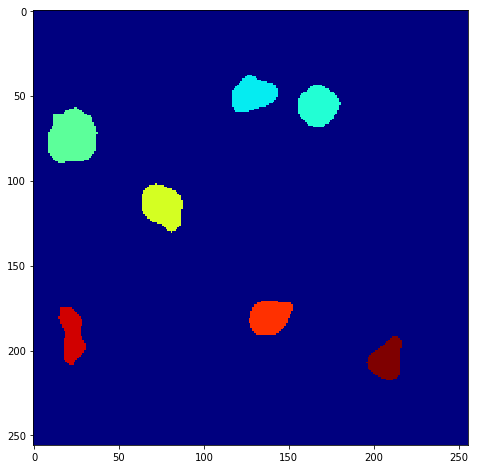

In [16]:
#min_size = ???  # Put your chosen value here
#max_size = ???  # Put your chosen value here
min_size = 100 # Put your chosen value here 
max_size = 800 # Put your chosen value here
filtered = (mh.labeled.remove_regions_where(watershed, sizes > max_size) &
            mh.labeled.remove_regions_where(watershed, sizes < min_size))

labeled, nr_objects = mh.labeled.relabel(filtered)
print("Number of cells: {}".format(nr_objects))

_ = plt.imshow(filtered)

## Calcium Imaging Analysis

First step is to get the indices of each ROI so that we can use them to measure the average intensity of each ROI at each frame.  


In [17]:
# Create an array of all the pixel locations (indices) of each pixel in each ROI
# Use this ROI location array to calculate the intensity of each pixel in each ROI
# ROI_list contains a list of all the arrays of x or y values for each ROI,
# such that ROI_list_xIndex[1] gives all the indices for the x values of ROI 1. 

ROI_list_xIndex = []
ROI_list_yIndex = []

for i in range(0, nr_objects):
    rois = np.where(labeled == i)
    rois = np.array(rois)
    x_index = rois[1,:]
    y_index = rois[0,:]
   
    ROI_list_xIndex.append(x_index)  #save an array of indices of each ROI to list ROI_array
    ROI_list_yIndex.append(y_index)
    
print(len(ROI_list_xIndex))
print(len(ROI_list_yIndex))

7
7


### Import the image series
There are a number of ways in python to load an image series. If you want to display the full movie, try using [CalBlitz](https://github.com/agiovann/CalBlitz), although it isn't compatible with Jupyter notebooks. CalBlitz also has features like motion correction and is optimized for in vivo calcium imaging. PIL, skimage and mahotas can also be used to import *.tif files. For now we'll use skimage to import a tif series into an array; the kernel will return its dimensions. 

In [18]:
import skimage.external.tifffile

filepath = 'MullerGliaImageSeriesSample.tif'

image_array = skimage.external.tifffile.imread(filepath, key = 0)
print(image_array.shape) #array shape should be 90 frames that are 256x256 pixels. 

(90, 256, 256)


Now we'll use our array of ROI indices and calculate the average intensity of each ROI over each frame and put that into a new array, avg_roi_array. 

In [19]:
# Now we have a list of arrays containing the indices of all the ROIs and a list of 256 x 256 
# pixelarrays containing information from each frame. Here we use the ROI indices to calculate
# average image intensity of each ROI at each frame, and then put that into an intensity array
# that we'll use to calculate dF/Fo. 

# Pre-allocate the array where you will store the average image intensities
avg_roi_array = np.zeros([len(ROI_list_yIndex), len(image_array)])

for j in range(len(ROI_list_yIndex)): #loop over all ROIs
    for i in range(len(image_array)): #loop over each time point
        # Select the image for the time point
        a = image_array[i]
        # Take the average intensity for the pixels within the ROI
        average_roi = np.average(a[ROI_list_yIndex[j], ROI_list_xIndex[j]])
        # Save the average 
        avg_roi_array[j, i] = average_roi

print(avg_roi_array.shape)

(7, 90)


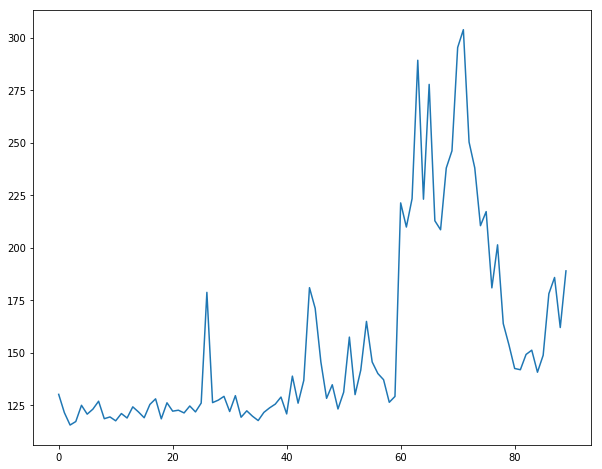

In [20]:
_ = plt.plot(avg_roi_array[3])  #plot one example trace

We can put the ROI array into a pandas DataFrame and then use pandas to plot each ROI to visually inspect the data. If you want to see the data frame, just uncomment the dfT and comment out the plt.show().  

In [21]:
import pandas as pd

df = pd.DataFrame(avg_roi_array)
dfT = df.T #Transpose the data frame so the columns are the ROIs. 

dfT #Print out entire dataframe

,0,1,2,3,4,5,6
0,68.079432,125.247642,132.185185,130.123159,126.216867,140.513382,71.448864
1,67.870970,126.568396,123.936819,121.398929,128.353414,129.982968,72.991477
2,67.569188,126.033019,124.111111,115.519411,124.188755,132.051095,74.142045
3,67.046371,121.601415,118.954248,117.179384,126.244980,134.038929,71.315341
4,69.180283,116.030660,129.710240,124.915663,119.363454,139.204380,75.900568
5,67.276204,121.759434,122.379085,120.700134,124.821285,130.756691,71.661932
6,67.357482,122.813679,116.644880,123.077644,121.797189,131.265207,77.642045
7,65.704881,119.646226,127.740741,126.855422,124.060241,130.226277,72.099432
8,65.129833,130.419811,126.089325,118.531459,131.192771,130.815085,76.636364
9,65.653870,121.398585,119.418301,119.374833,121.668675,131.114355,72.690341


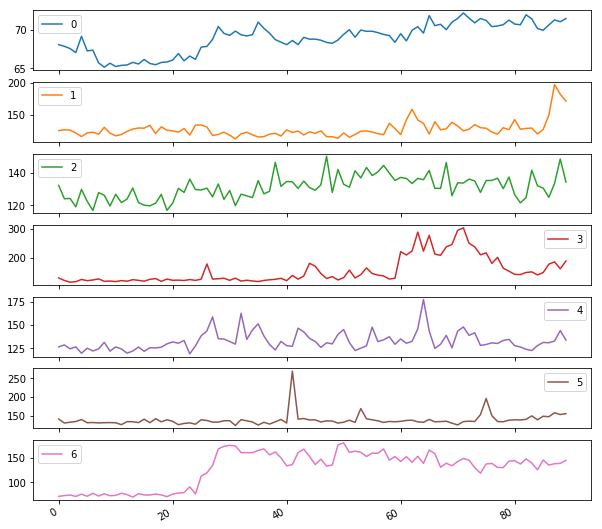

In [22]:
_ = dfT.plot(subplots = True, figsize = (10, 10), legend = True)

### Calculate delta F/F  

$$\Delta F/F$$ 

As you can see from the axis, there are some real responses and some that are just noise around baseline. Usually you'll want to do some signal filtering and processing to identify the real calcium transient 'events' from the noise, but I'll let you figure out your favorite way to do that. 

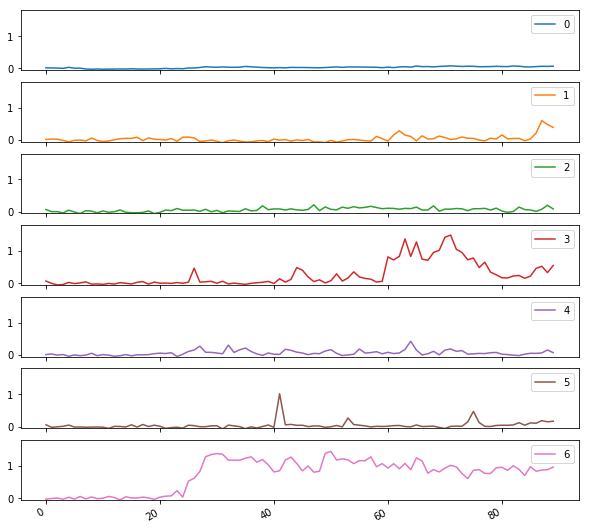

In [23]:
#Now calculate deltaF/F0 on the dataset. For F0 I'll use an average of the first 10 frames. 
roi = np.array(df)
fo = np.zeros([len(df)], dtype = float)
deltaF = np.zeros([len(df), len(roi[1,:])])
for i in range(len(df)): 
    new_roi = roi[i]
    fo[i] = np.average(roi[i,0:10]) #calculate F0 for each roi
    deltaF[i] = ((roi[i] - fo[i])/fo[i]) #calculate deltaF/F0 for each ROI
    

deltaF_df = pd.DataFrame(deltaF)
deltaF_df = deltaF_df.T

ymin = -.05
ymax = 1.8
deltaF_df.plot(subplots = True, figsize = (10, 10), legend = True, ylim = (ymin, ymax))

plt.ylim((ymin, ymax)) 
plt.show()